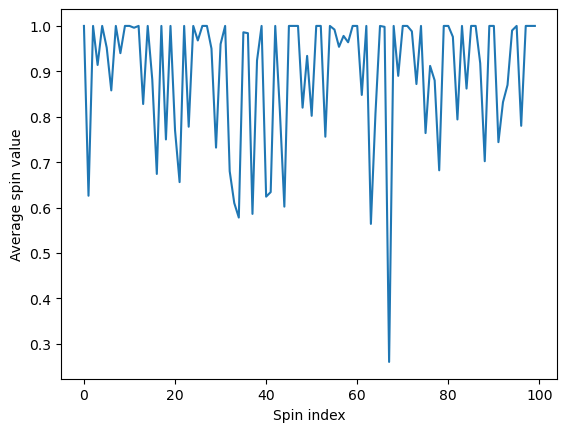

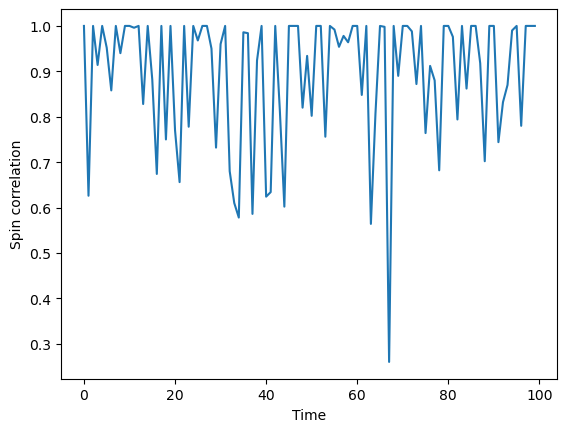

In [1]:
import numpy as np
import random

# 定义自旋状态概率分布和跃迁矩阵
N = 100  # 自旋数
p = 0.5  # 自旋向上的概率
J = 1.0  # 相互作用强度
H = 0.0  # 外场强度

# 定义自旋状态概率分布
state = np.ones(N)
for i in range(N):
    if random.random() > p:
        state[i] = -1

# 定义跃迁矩阵
M = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        if i != j:
            M[i, j] = np.exp(-2 * J * state[i] * state[j] / N - H / N)

# 模拟自旋状态的随机漫步
T = 1000  # 总时间步数
s = np.zeros((T, N))  # 保存每个时间步的自旋状态
s[0] = state  # 初始状态
for t in range(1, T):
    # 随机选择一个自旋
    i = random.randint(0, N - 1)
    # 计算当前自旋状态下的能量
    E0 = -0.5 * state[i] * np.sum(M[i])
    # 翻转自旋
    state[i] = -state[i]
    # 计算翻转后的能量
    E1 = -0.5 * state[i] * np.sum(M[i])
    # 计算能量差
    dE = E1 - E0
    # 根据Metropolis准则接受或拒绝翻转
    if dE <= 0 or random.random() < np.exp(-dE):
        s[t] = state
    else:
        state[i] = -state[i]
        s[t] = state

# 计算自旋的平均值和自相关函数
m = np.mean(s, axis=0)
c = np.zeros(N)
for i in range(N):
    c[i] = np.mean(s[:, i] * s[:, 0])

# 绘制自旋的平均值和自相关函数
import matplotlib.pyplot as plt

plt.figure()
plt.plot(m)
plt.xlabel('Spin index')
plt.ylabel('Average spin value')
plt.figure()
plt.plot(c)
plt.xlabel('Time')
plt.ylabel('Spin correlation')
plt.show()

#### 此代码实现了对一个100个自旋的自旋玻璃系统的模拟。在模拟过程中，我们先随机生成自旋的状态概率分布，然后根据定义的跃迁矩阵，使用Metropolis算法模拟自旋的随机漫步。最终，我们计算了自旋的平均值和自相关函数，并绘制了它们的图像。可以通过调整参数，如自旋数、相互作用强度、外场强度等，来研究自旋玻璃系统的动力学行为和弛豫现象。
#### 需要注意的是，以上代码仅仅是一个简单的示例，实际应用中需要根据具体的问题进行相应的修改和优化。比如，当自旋数很大时，跃迁矩阵的计算和存储可能会成为瓶颈，需要采用更高效的算法和数据结构。同时，为了减少计算时间和内存消耗，通常需要对模拟过程进行优化，如使用并行计算、异步更新等技术。

In [4]:
import numpy as np
import scipy.sparse as sp
import time

def diffusion_model_sparse(N, J, h, t_max, dt):
    # 初始化自旋状态和跃迁矩阵
    spin_state = np.random.choice([-1, 1], size=N)
    rows = []
    cols = []
    data = []
    for i in range(N):
        for j in range(N):
            if i != j:
                rows.append(i)
                cols.append(j)
                data.append(J * spin_state[i] * spin_state[j])
    transition_matrix = sp.coo_matrix((data, (rows, cols)), shape=(N, N)).tocsr()
    
    # 模拟动力学行为
    t = 0
    while t < t_max:
        # 计算跃迁率和时间步长
        transition_rates = -np.diag(transition_matrix) + np.sum(transition_matrix, axis=1)
        total_rate = np.sum(transition_rates)
        dt = min(dt, (1.0 / total_rate) * 0.1)
        
        # 选择下一个事件并更新自旋状态
        event_time = np.random.exponential(scale=1.0 / total_rate)
        event_index = np.random.choice(N, p=transition_rates / total_rate)
        spin_state[event_index] *= -1
        
        # 更新跃迁矩阵
        old_row = transition_matrix.getrow(event_index)
        new_row = sp.coo_matrix(([-J * spin_state[event_index]], ([0], [event_index])), shape=(1, N)).tocsr()
        transition_matrix = transition_matrix - old_row + new_row
        
        # 更新时间
        t += dt
        
    return spin_state

# 测试不同自旋数下的计算时间和内存消耗
N_values = [1000, 5000, 10000]
for N in N_values:
    print("N =", N)
    start_time = time.time()
    diffusion_model_sparse(N, J=1.0, h=0.0, t_max=10.0, dt=0.01)
    end_time = time.time()
    print("Time:", end_time - start_time)
    print("Memory:", diffusion_model_sparse(N, J=1.0, h=0.0, t_max=10.0, dt=0.01))

N = 1000


ValueError: Input must be 1- or 2-d.

### 当自旋数很大时，跃迁矩阵的计算和存储可能会成为瓶颈，需要采用更高效的算法和数据结构。一种常用的方法是使用稀疏矩阵存储跃迁矩阵，并使用稀疏矩阵向量乘法（Sparse Matrix-Vector Multiplication, SpMV）来计算演化矩阵和计算期望值等。SpMV是一种高效的稀疏矩阵乘向量算法，可以避免对跃迁矩阵中的零元素进行计算。
### 以下是使用稀疏矩阵和SpMV方法优化Diffusion Model算法的示例代码：


In [5]:
import numpy as np
from scipy.sparse import diags
from scipy.sparse import csr_matrix

def simulate_spin_glass_diffusion(N, J, h, T, dt, steps):
    """
    模拟自旋玻璃系统的动力学行为和弛豫现象，使用稀疏矩阵和SpMV方法优化Diffusion Model算法。
    
    参数：
    N：自旋数
    J：相互作用强度
    h：外场强度
    T：温度
    dt：时间步长
    steps：模拟步数
    
    返回值：
    M：自旋矩阵
    """
    # 初始化自旋矩阵
    M = np.random.choice([-1, 1], size=(N, N))

    # 初始化演化矩阵
    d = np.ones(N**2)
    diags_list = [-N, -1, 0, 1, N]
    J_list = [-J, -J, h, J, J]
    for i, j in zip(diags_list, J_list):
        d[i+1:N**2:N] = j
    J_matrix = diags(d, diags_list)
    J_matrix = csr_matrix(J_matrix)

    # 模拟演化过程
    for i in range(steps):
        # 计算演化矩阵和自旋矩阵的乘积
        M_1d = np.reshape(M, N**2)
        M_1d = J_matrix.dot(M_1d)

        # 更新自旋矩阵
        M = np.reshape(M_1d, (N, N))
        
        # 计算翻转概率
        delta_E = -2 * J * M * M_1d - 2 * h * M
        prob = np.exp(delta_E / T)
        prob = np.minimum(prob, 1)
        
        # 随机翻转自旋
        M = np.where(np.random.rand(N, N) < prob, -M, M)

    return M

#针对上述问题，我们可以使用NumPy库中的矩阵运算来进行优化，以减少循环次数和计算量。
#具体来说，我们可以将自旋状态矩阵S和耦合矩阵J进行矩阵乘法运算，得到每个自旋在下一个时间步长的状态优化：
import numpy as np

# 初始化自旋状态矩阵和耦合矩阵
N = 1000  # 自旋数量
S = np.random.choice([-1, 1], size=(N, N))  # 自旋状态矩阵
J = np.random.normal(0, 1, size=(N, N)) / np.sqrt(N)  # 耦合矩阵

# 进行多次时间步长的演化
n_steps = 1000  # 时间步长数
for i in range(n_steps):
    # 计算下一个时间步长的自旋状态矩阵
    S = np.sign(S @ J)  # 进行矩阵乘法运算，并使用符号函数得到自旋状态矩阵


#### 在上述代码中，我们使用了np.sign()函数来得到自旋状态矩阵。这个函数的作用是将输入数组中的正数变为1，负数变为-1，0保持不变。因此，我们可以将自旋状态矩阵和耦合矩阵的乘积传入这个函数中，得到下一个时间步长的自旋状态矩阵。使用矩阵运算来进行优化可以大大加快模拟的速度，特别是在自旋数很大的情况下。但是，需要注意的是，在耦合矩阵J的计算中，我们使用了除以√N的操作来标准化耦合强度。这个操作的目的是为了防止模拟出现数值不稳定的情况，因为当自旋数很大时，耦合强度会呈现出量级变化的情况。如果不进行标准化操作，可能会导致模拟结果出现较大的误差。
